In [1]:
import ot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

from utils.plot import make_grid
from utils.classif import eval_clf
from utils.plot import scatterplot
from utils.plot import plot_contours
from utils.plot import discrete_gamma_marg
from utils.plot import plot_gamma_with_marginals
from utils.preprocessing import feature_scaling

from domain_adaptation.divergences import h_divergence
from domain_adaptation.divergences import wasserstein_distance
from domain_adaptation.divergences import maximum_mean_discrepancy
from domain_adaptation.divergences import subspace_disagreement_measure

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

plt.style.use('science')

plt.rcParams['mathtext.fontset'] = 'custom' 
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans' 
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic' 
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold' 
plt.rcParams['font.size'] = 16 
plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral'

palette = sns.color_palette('tab10', n_colors=5)
palette_cmap = ListedColormap(palette.as_hex())

Using TensorFlow backend.


## Distributional Shift vs. Parameter Mismatch

In [2]:
data = np.load('./data/1_ttanks_acf_0.05.npy')
X = data[:, :-2].copy()
X = feature_scaling(data[:, :-2])
data[:, :-2] = X.copy()
D = data[:, -1]
Xs = X[np.where(D == 0)[0]]
ys = data[np.where(D == 0)[0], -2]

features_targets = [
    X[np.where(D == i)[0]] for i in range(1, len(np.unique(D)))
]
labels_targets = [data[np.where(D == i)[0], -2] for i in range(1, len(np.unique(D)))]

In [3]:
clf = LinearSVC(penalty='l2', loss='squared_hinge', C=10, max_iter=1e+5)

param_noise = np.linspace(0, 1, 20)[1:]
pnoise = np.zeros([len(np.unique(D)) - 1, 10])
wdists = np.zeros([len(np.unique(D)) - 1, 10])
hdivs = np.zeros([len(np.unique(D)) - 1, 10])
mmds = np.zeros([len(np.unique(D)) - 1, 10])
rods = np.zeros([len(np.unique(D)) - 1, 10])

for i in range(len(np.unique(D)) - 1):
    Xt = features_targets[i]
    yt = labels_targets[i]
    
    for j in range(10):
        pnoise[i, j] = param_noise[i]
        Xtr, _, ytr, _ = train_test_split(Xs, ys, train_size=0.8, stratify=ys)
        Xts, _, yts, _ = train_test_split(Xt, yt, train_size=0.8, stratify=yt)
        wdist = wasserstein_distance(Xtr, Xts)
        wdists[i, j] = wdist
        hdivs[i, j] = h_divergence(Xtr, Xts, clf=clf)
        mmds[i, j] = maximum_mean_discrepancy(Xtr, Xts, kernel='linear')

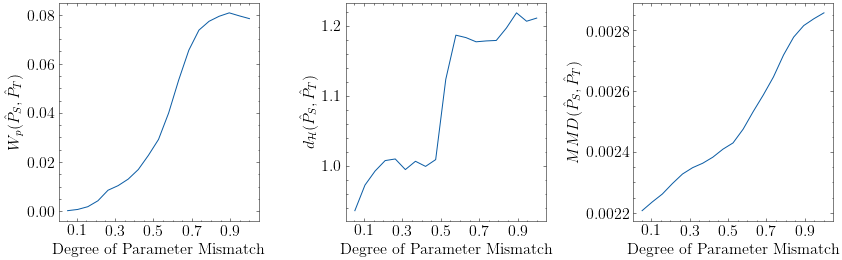

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(np.mean(pnoise, axis=1), np.mean(wdists, axis=1))
axes[0].set_ylabel(r'$W_{p}(\hat{P}_{S}, \hat{P}_{T})$')
axes[0].set_xlabel(r'Degree of Parameter Mismatch')
_ = axes[0].set_xticks([i / 10 for i in range(1, 11, 2)])

axes[1].plot(np.mean(pnoise, axis=1), np.mean(hdivs, axis=1))
axes[1].set_ylabel(r'$d_{\mathcal{H}}(\hat{P}_{S}, \hat{P}_{T})$')
axes[1].set_xlabel(r'Degree of Parameter Mismatch')
_ = axes[1].set_xticks([i / 10 for i in range(1, 11, 2)])

axes[2].plot(np.mean(pnoise, axis=1), np.mean(mmds, axis=1))
axes[2].set_ylabel(r'$MMD(\hat{P}_{S}, \hat{P}_{T})$')
axes[2].set_xlabel(r'Degree of Parameter Mismatch')
_ = axes[2].set_xticks([i / 10 for i in range(1, 11, 2)])

plt.tight_layout()

plt.savefig('./Figures/Ch5/Divergencies.pdf', transparent=True)